<h1>Vessel Detector</h1>



<h4>Setup</h4>

In [1]:
# tensorflow libraries
import tensorflow as tf
#import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.autograph.experimental as exp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization,Reshape,UpSampling2D,MaxPooling2D,LeakyReLU,Dropout, Conv2DTranspose
import tensorflow.keras.backend as kb
#tfd = tfp.distributions
#tfb = tfp.bijectors
#tfpl = tfp.layers

import os
from os.path import dirname, abspath

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# %matplotlib inline
print('Libraries Initialised')
print("-> TF version:", tf.__version__)
#print("-> TFP version:", tfp.__version__)

Libraries Initialised
-> TF version: 2.5.0


In [2]:
# check if GPU is installed
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
if not tf.test.gpu_device_name(): 
    warnings.warn('NO GPU DETECTED. CPU will be attempted to be used')
else: 
    print('GPU DETECTED: Default GPU {}' .format(tf.test.gpu_device_name()))

GPU DETECTED: Default GPU /device:GPU:0


<h4>Initalise Variables</h4>

In [3]:
inShape = [128,128,3]
tfShape = [128,128,1]

latent_dims = 896
nLayers = 3
doSeed = 2021
epochs = 200 #20good

In [4]:
# initalise file structure, including data locations
src_dir = dirname(abspath(os.getcwd()))                         # source directory

# i am growing a strong distaste for Windows...
train_dir = (src_dir + "/data/128Aug/training/train")           # train directory
test_dir = (src_dir + "/data/128Aug/testing/test/")      # test directory
log_dir = os.path.normpath(abspath(os.getcwd()) + "/_logs")     # log directory - for run info
res_dir = os.path.normpath(abspath(os.getcwd()) + "/_results")  # results directory

dirs = [train_dir, test_dir, log_dir, res_dir]                  # place directories in list

for i in range(0, len(dirs)):
    if not os.path.exists(dirs[i]):
        os.makedirs(dirs[i])
    
print("File Structure Initalised.\n-> Results: ", res_dir,"\n-> Logs:",log_dir)

File Structure Initalised.
-> Results:  F:\_code\GitHub\IRP\jupyterLab\_results 
-> Logs: F:\_code\GitHub\IRP\jupyterLab\_logs


<h4>Define Functions</h4>

In [5]:
# define functions to load images from file paths
def load_image(filepath):
    raw_img = tf.io.read_file(filepath) 
    img_tensor_int = tf.image.decode_png(raw_img, channels=3)
    img_tensor_flt = tf.image.convert_image_dtype(img_tensor_int, tf.float32)
    return img_tensor_flt, img_tensor_flt

def load_test(split):
    train_list_ds = tf.data.Dataset.list_files((test_dir+"{}/*.png").format(split), shuffle=True)
    train_ds = train_list_ds.map(exp.do_not_convert(load_image))
    return train_ds

def load_data(pth):
    train_list_ds = tf.data.Dataset.list_files(pth, shuffle=True)
    train_ds = train_list_ds.map(exp.do_not_convert(load_image))
    print('[DATA LOADED]')
    return train_ds

In [6]:
# define function to split dataset into training and validation sets
def split_dataset(ds, ds_size, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=1000):
    assert (train_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=2021)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds

In [7]:
# function for calculating evaluation metrics

def compute_metrics(y_true, y_pred):

    conf_mat = confusion_matrix(y_true = y_true, y_pred = y_pred)

    true_positives = conf_mat[1,1]
    true_negatives = conf_mat[0, 0]
    
    false_positives = conf_mat[0, 1]
    false_negatives = conf_mat[1,0]

    model_precision = true_positives/(true_positives+false_positives)
    print("Model precision is: "+str(model_precision))

    model_recall = true_positives/(true_positives+false_negatives)
    print("Model recall is: "+str(model_recall))

    f1_score = 2*(model_precision*model_recall)/(model_precision+model_recall)
    print("Model f1 score is: "+str(f1_score))

    model_acc = (true_positives+true_negatives)/(len(y_true))
    print("Model accuracy is: "+str(model_acc))
    
    return model_precision, model_recall, f1_score, model_acc

In [8]:
# define conditioner function to ensure input data is suitable for operation
def condition(dataset, inShape):
    def reshaper(inp,out):
        return tf.reshape(inp,inShape),tf.reshape(out,inShape)

    def reducer(inp,out):
        return tf.reduce_mean(inp,axis=-1,keepdims=True),tf.reduce_mean(out,axis=-1,keepdims=True)
    
    def nanaway(inp,out):
        return tf.clip_by_value(inp, 0, 1),tf.clip_by_value(out, 0, 1)
    
    def normaliser(inp,out):
        return inp/tf.reduce_max(inp,axis=None),out/tf.reduce_max(inp,axis=None)
    
    return dataset.map(exp.do_not_convert(reshaper)).map(exp.do_not_convert(reducer)).map(exp.do_not_convert(normaliser)).map(exp.do_not_convert(nanaway))

<h4>Import Data</h4>

In [9]:
test_limit = 15000

ds = load_data(train_dir + "/*.png")
ds = ds.take(test_limit)
ds = condition(ds, inShape)

print(ds.element_spec)

x_train, x_val = split_dataset(ds, test_limit)

[DATA LOADED]
(TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))


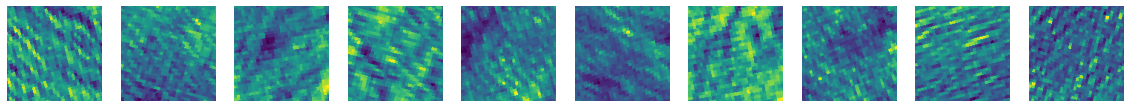

In [10]:
# have a quick look at the samples to make sure they're loaded/shuffled properly...
samples = 10
imgs = x_train.take(samples)

fig, axs = plt.subplots(1, samples)
fig.set_figheight(20)
fig.set_figwidth(20)
for i, img in enumerate(imgs):
    axs[i].imshow(img[0])
    axs[i].axis('off')
    
    


<h4>Setup the Autoencoder</h4>

In [11]:
# define autoencoder parameters
params = dict()
params["e_filters"] = [32, 64, 128]               # filter order for the encoder
params["e_kernels"] = [3, 3, 3]                 # kernel order for the encoder
params["e_strides"] = [2, 2, 2]                 # stride order for the encoder
params["e_paddings"] = ["same" for _ in range(nLayers)] 
params["e_dropouts"] = [.0, .2, .4]

params["d_filters"] = [128, 64, 32]               # filter order for the decoder
params["d_kernels"] = [2, 2, 2]                 # kernel order for the decoder
params["d_strides"] = [1, 1, 1]                 # stride order for the decoder
params["d_paddings"] = ["same" for _ in range(nLayers)]
params["d_dropouts"] = [.4, .2, .0]             # dropout intensities

In [12]:
e_in = tf.keras.Input(shape=tfShape, name="input_layer")
lyr = e_in
# build the encoder
for i in range(0, nLayers):
    
    lyr = Conv2D(
        filters = params["e_filters"][i],
        kernel_size = params["e_kernels"][i],
        strides = params["e_strides"][i],
        padding = params["e_paddings"][i]
    )(lyr)
    
    lyr = BatchNormalization(name = str("Batch" + str(i)))(lyr)
    lyr = LeakyReLU(alpha=0.2)(lyr)
    lyr = Dropout(
        rate = params["e_dropouts"][i],
        seed = doSeed
       )(lyr)

e_shape = kb.int_shape(lyr)
lyr = Flatten()(lyr)
f_shape = kb.int_shape(lyr)
e_out = Dense(latent_dims)(lyr)

encoder = Model(e_in,e_out,name="encoder")

In [13]:
# define the decoder
d_in = tf.keras.Input(shape=(latent_dims,))
lyr = d_in
lyr = Dense(f_shape[1], activation='sigmoid')(lyr)
lyr = Reshape((e_shape[1],e_shape[2],e_shape[3]))(lyr)

# build the decoder
for i in range(0, nLayers):
    
    lyr = Conv2DTranspose(
        filters = params["d_filters"][i],
        kernel_size =  params["d_kernels"][i],
        strides = params["d_strides"][i],
        padding = params["d_paddings"][i]
    )(lyr)
    lyr = BatchNormalization(name = str("Batch" + str(i)))(lyr)
    lyr = LeakyReLU(alpha=0.2)(lyr)
    lyr = UpSampling2D()(lyr)
    lyr = Dropout(
        rate = params["d_dropouts"][i],
        seed = doSeed
    )(lyr)

# formulate output
d_out = Conv2DTranspose(
    filters = tfShape[2],
    kernel_size = 3, 
    strides = 1, 
    padding = "same",
    activation = "sigmoid",
    name = "Output_Layer"
)(lyr)


#d_out = Reshape((128,128,1))(lyr)
decoder = Model(d_in,d_out,name="decoder")


In [14]:
print("\n##### ENCODER #####")
encoder.summary()
print("\n\n##### DECODER #####")
decoder.summary()


##### ENCODER #####
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
Batch0 (BatchNormalization)  (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
Batch1 (BatchNormalization)  (None, 32

In [15]:
autoencoder = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
Batch0 (BatchNormalization)  (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
Batch1 (BatchNormalization)  (None, 32, 32, 64)        256   

In [16]:
x_train = x_train.batch(100,drop_remainder=True)
x_val = x_val.batch(100, drop_remainder=True)

<h4>Train the Autoencoder</h4>

Note, when not running on Google colab you may recieve an error message regarding the transform of a function. As per this <a href=https://github.com/tensorflow/tensorflow/issues/37144#issuecomment-600350256>GitHub thread</a> it can be safely ignored, and is used as a debugging tool.

In [17]:
#encoder.trainable=True
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

def ssimLF(inImg, predImg):
    loss_fn = (1 -  tf.reduce_mean(tf.image.ssim(inImg, predImg, 1.0)))/2 # https://docs.w3cub.com/tensorflow~python/tf/reduce_mean.html
    # https://medium.com/@majpaw1996/anomaly-detection-in-computer-vision-with-ssim-ae-2d5256ffc06b
    return loss_fn 

autoencoder.compile(optimizer=optimizer, loss=exp.do_not_convert(ssimLF))
history = autoencoder.fit(x_train, epochs=epochs, validation_data=x_val, verbose = 1)

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Constant constructor takes either 0 or 2 positional arguments
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Constant constructor takes either 0 or 2 positional arguments
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
120/120 [==============================] - ETA: 0s - loss: 0.2741WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001EEE97CC670> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

<h4>Visualise Autoencoder Performance</h4>

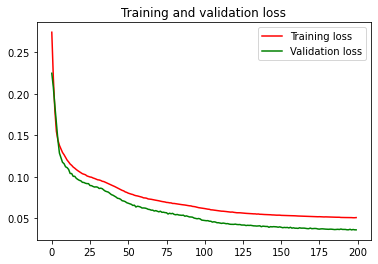

In [18]:
# plot loss charts
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_r = range(epochs)
plt.figure()
plt.plot(epochs_r, loss, 'r', label='Training loss')
plt.plot(epochs_r, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
boats_ds_o = load_test('boat')
sea_ds_o = load_test('sea')

In [20]:
boats_ds = condition(boats_ds_o, inShape)
sea_ds = condition(sea_ds_o, inShape)

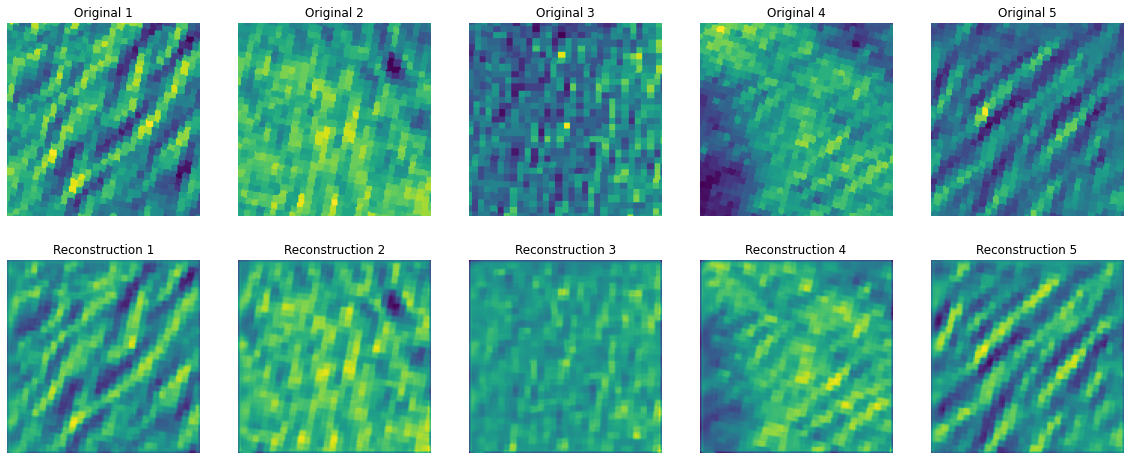

In [29]:
# view orignal and reconstructed versions of sea
iterable = iter(sea_ds.batch(20))
fig,axs=plt.subplots(2,5,figsize=(20,8))
img = iterable.next()[0]
#img = x_test_cnn[:6]
reconstruction = autoencoder(img)

for i in range(5):

    axs[0,i].imshow(tf.squeeze(img[i]))
    axs[0,i].title.set_text(f"Original {i+1}")
    axs[0,i].set_axis_off()
    axs[1,i].imshow(tf.squeeze(reconstruction[i]))
    axs[1,i].title.set_text(f"Reconstruction {i+1}")
    axs[1,i].set_axis_off()

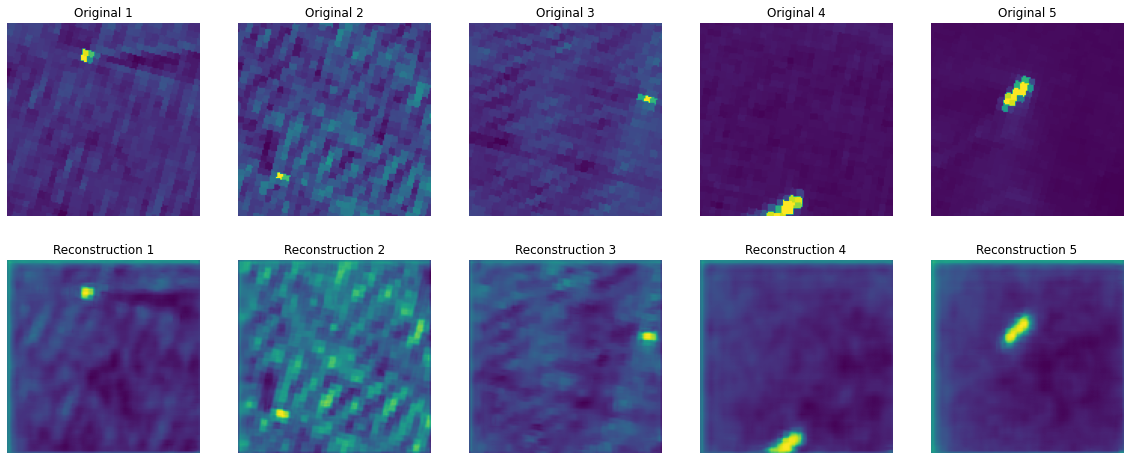

In [22]:
# view orignal and reconstructed versions of boats
iterable_boats = iter(boats_ds.batch(20))
fig,axs=plt.subplots(2,5,figsize=(20,8))
imgb = iterable_boats.next()[0]
#img = x_test_cnn[:6]
reconstruction = autoencoder(imgb)

for i in range(5):

    axs[0,i].imshow(tf.squeeze(imgb[i]))
    axs[0,i].title.set_text(f"Original {i+1}")
    axs[0,i].set_axis_off()
    axs[1,i].imshow(tf.squeeze(reconstruction[i]))
    axs[1,i].title.set_text(f"Reconstruction {i+1}")
    axs[1,i].set_axis_off()

In [23]:
# setup labels for evaluating autoencoder performance
sea_imgs=[]
for j, images in enumerate(sea_ds.take(200)):
    sea_imgs.append(images[0])
boat_imgs=[]
for j, images in enumerate(boats_ds.take(200)):
    boat_imgs.append(images[0])

In [24]:
sea_tensor= np.array(sea_imgs)
boat_tensor = np.array(boat_imgs)

y_test_boats = []
y_test_sea = []

for i in range(0, len(boat_tensor)):
    y_test_boats.append(1)
    
for i in range(0, len(sea_tensor)):
    y_test_sea.append(0)

y_test = np.concatenate((y_test_sea, y_test_boats), axis=0)
test_tensor = np.concatenate((sea_tensor, boat_tensor), axis=0)
test_tensor.shape
print(y_test.shape)

(400,)


In [25]:
#display first 10 latent representations
enc_out = encoder(img)
print(enc_out[0:2])

enc_outb = encoder(imgb)
print(enc_outb[0:2])


tf.Tensor(
[[-10.682884     3.9904656    0.26382875 ...  -5.953061     0.36103112
   -1.5342109 ]
 [ -0.2115365    3.7010715    3.4803119  ...   0.14128807   0.47481507
    0.86342037]], shape=(2, 896), dtype=float32)
tf.Tensor(
[[-0.37512907 -5.1783605  -1.2712685  ... -0.76305497 -2.6820517
   0.19561529]
 [-0.98368186 -1.5838556  -0.94521594 ...  4.644888   10.155325
   6.618017  ]], shape=(2, 896), dtype=float32)


In [26]:
#fig,axs=plt.subplots(2,5,figsize=(20,8))
test_tensor_c = tf.concat((sea_tensor, boat_tensor), axis=0)

print(sea_tensor.shape)
print(boat_tensor.shape)
print(test_tensor_c.shape)


for i in range(len(test_tensor_c)):
    img = test_tensor_c[i][None,...]
    output = encoder(img)
    
    if i == 0:
        outTensor = output
        
    else:
        outTensor = tf.concat([outTensor,output], axis=0)

    




(200, 128, 128, 1)
(200, 128, 128, 1)
(400, 128, 128, 1)


tf.Tensor(
[[ -1.556029     2.2669518   -2.9456816  ...  -0.23765424  -0.7425172
    3.7682707 ]
 [  6.192       -3.2989883   -1.2722657  ...  -8.747692    -2.0519824
  -11.487715  ]
 [ -2.1905422   -6.5826635    4.4287324  ...   2.0935435    1.1175711
    1.496231  ]
 ...
 [  7.729096    -4.3439307   -4.445856   ...   0.5043313   -1.1074729
   -2.1490428 ]
 [ -0.14417015  -6.0040135    6.600999   ...  12.75794     -8.091297
    1.7889239 ]
 [  7.211697    -3.0417118   -4.287527   ...   6.082108     6.041976
   -3.1628098 ]], shape=(400, 896), dtype=float32)


(400, 2)

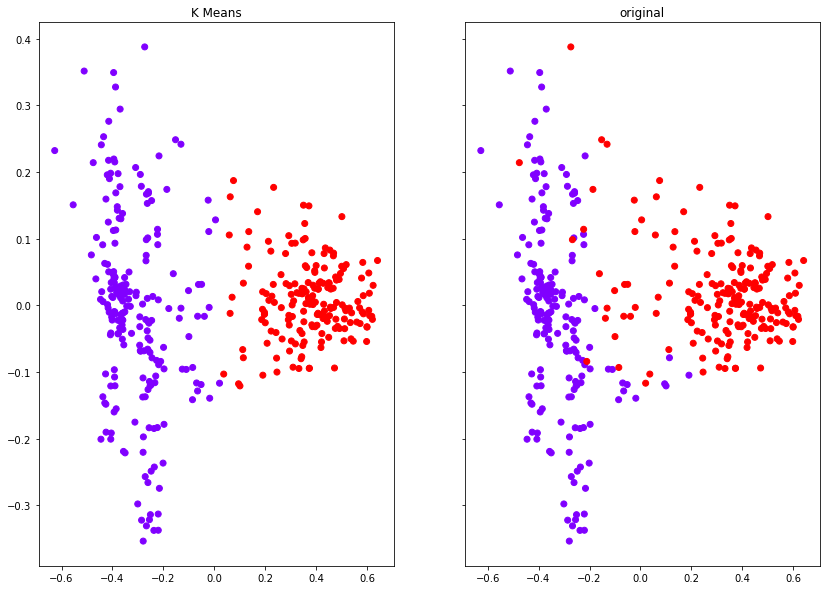

In [27]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# perform k menas
print(outTensor)
normalised_data = normalize(outTensor) 

from sklearn.cluster import KMeans
from sklearn import metrics

km = KMeans(n_clusters = 2)
km.fit(normalised_data)



km_labels = km.labels_

# TODO now PCA...
pca_2d = PCA(n_components=2)  #Principal component analysis object, for projecting data into 2D
encoder_projected = pca_2d.fit_transform(normalised_data) #PCA


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,10))
ax1.set_title('K Means')
ax1.scatter(encoder_projected[:,0],encoder_projected[:,1],c=km_labels,cmap='rainbow')

ax2.set_title('original')
ax2.scatter(encoder_projected[:,0],encoder_projected[:,1],c=y_test,cmap='rainbow')

encoder_projected.shape

In [28]:
#TODO: 

km_metrics = compute_metrics(y_test, km_labels)

Model precision is: 0.9779005524861878
Model recall is: 0.885
Model f1 score is: 0.9291338582677167
Model accuracy is: 0.9325
